In [40]:
# Cellule 1: Import des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
# Cellule 2: Sélection et chargement du fichier TIF
# Remplacez ce chemin par votre propre fichier TIF
input_file = r"D:\UQTR\Hiver 2025\Télédétection\TP3\TR_clip.tif"

# Ouvrir le fichier pour l'analyse
src = rasterio.open(input_file)

# Informations sur l'image
print(f"Informations sur l'image {os.path.basename(input_file)}:")
print(f"Dimensions: {src.width} x {src.height} pixels")
print(f"Nombre total de bandes: {src.count}")
print(f"Type de données: {src.dtypes[0]}")
if src.crs:
    print(f"Système de coordonnées: {src.crs.to_string()}")

# Afficher la liste des bandes
print("\nBandes disponibles:")
for i in range(1, src.count + 1):
    desc = src.descriptions[i-1] if src.descriptions and i-1 < len(src.descriptions) else "Non spécifiée"
    print(f"  Bande {i}: {desc}")

Informations sur l'image TR_clip.tif:
Dimensions: 1071 x 637 pixels
Nombre total de bandes: 18
Type de données: float32
Système de coordonnées: EPSG:32618

Bandes disponibles:
  Bande 1: B02_10m
  Bande 2: B03_10m
  Bande 3: B04_10m
  Bande 4: B05_20m
  Bande 5: B06_20m
  Bande 6: B07_20m
  Bande 7: B08_10m
  Bande 8: B11_20m
  Bande 9: B12_20m
  Bande 10: AOT_10m
  Bande 11: WVP_10m
  Bande 12: SCL_20m
  Bande 13: NDVI
  Bande 14: None
  Bande 15: Isodata Unsupervised_1
  Bande 16: Isodata Unsupervised_2
  Bande 17: None
  Bande 18: Isodata Unsupervised


In [ ]:
# Cellule 4: Sélection manuelle des bandes pour le NDVI
# Modifiez ces valeurs après avoir examiné les bandes disponibles
red_index = 3  # Exemple: Bande rouge (B04 pour Sentinel-2)
nir_index = 7  # Exemple: Bande PIR (B08 pour Sentinel-2)

# Visualiser les bandes sélectionnées
red_band = src.read(red_index)
nir_band = src.read(nir_index)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
show(red_band, ax=ax1, cmap='Reds', title=f"Bande Rouge ({red_index})")
show(nir_band, ax=ax2, cmap='Greens', title=f"Bande PIR ({nir_index})")
plt.tight_layout()
plt.show()

print(f"Bandes sélectionnées pour le calcul du NDVI:")
print(f"  Bande rouge: {red_index}")
print(f"  Bande PIR: {nir_index}")

In [6]:
# Cellule 5: Fonctions utilitaires pour le traitement
def load_band(image_path, band_index):
    """Charge une bande spécifique de l'image"""
    with rasterio.open(image_path) as src:
        band = src.read(band_index)
        profile = src.profile.copy()
    return band, profile

def save_raster(data, profile, output_path, dtype=None):
    """Sauvegarde un raster au format GeoTIFF"""
    if dtype:
        profile.update(count=1, dtype=dtype, compress='lzw')
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)
    print(f"Fichier sauvegardé: {output_path}")

In [76]:
# Cellule 7: Classification IsoData avec tous les paramètres

###########################################
#        CONFIGURATION DE L'ANALYSE       #
###########################################

# 1. SÉLECTION DES BANDES
# Indiquez les numéros des bandes à utiliser (basé sur l'affichage des bandes disponibles)
SELECTED_BANDS = [2,4,7,13]

# 2. PARAMÈTRES PRINCIPAUX DE L'ALGORITHME ISODATA
N_CLUSTERS_MIN = 5    # Nombre minimum de clusters
N_CLUSTERS_MAX = 10    # Nombre maximum de clusters
MAX_ITERATIONS = 80   # Nombre maximum d'itérations

# 3. PARAMÈTRES AVANCÉS DE DIVISION/FUSION
MIN_SAMPLES = 40       # Nombre minimum d'échantillons par cluster
MAX_STD_DEV = 0.3      # Écart-type maximum dans un cluster avant division
MIN_DIST = 0.6         # Distance minimale entre clusters pour fusion
MAX_MERGE_PAIRS = 3   # Nombre maximum de paires de clusters à fusionner par itération

# 4. PARAMÈTRES DE CONVERGENCE
CONVERGENCE_THRESHOLD = 0.02  # Seuil de convergence (% de pixels changeant de cluster)

In [74]:

###########################################
#       EXÉCUTION DE LA CLASSIFICATION    #
###########################################

print("Classification non-supervisée avec IsoData...")
print(f"Utilisation de {len(SELECTED_BANDS)} bandes: {SELECTED_BANDS}")

# 1. Chargement des bandes sélectionnées
bands_data = []
band_names = []

for i in SELECTED_BANDS:
    # Lecture de la bande
    band = src.read(i)
    name = src.descriptions[i-1] if i-1 < len(src.descriptions) else f"Bande {i}"
    bands_data.append(band)
    band_names.append(name)
    print(f"  ✓ Bande {i}: {name} chargée")
    
# 2. Vérification et redimensionnement des bandes
reference_shape = bands_data[0].shape
for i, band in enumerate(bands_data):
    if band.shape != reference_shape:
        print(f"  Redimensionnement de '{band_names[i]}' à {reference_shape}")
        from skimage.transform import resize
        bands_data[i] = resize(band, reference_shape, preserve_range=True)

# 3. Création du stack de bandes
stack = np.stack(bands_data)
n_bands, height, width = stack.shape
print(f"Stack de dimensions: {n_bands} bandes x {height} lignes x {width} colonnes")

# 4. Préparation des données pour le clustering
data_for_clustering = stack.reshape(n_bands, -1).T
valid_pixels = ~np.isnan(data_for_clustering).any(axis=1)
valid_data_raw = data_for_clustering[valid_pixels]

# 5. Normalisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
valid_data = scaler.fit_transform(valid_data_raw)
print(f"Données normalisées: {valid_data.shape[0]} pixels valides avec {n_bands} dimensions")

# 6. Initialisation avec KMeans
print(f"Initialisation avec {N_CLUSTERS_MIN} classes...")
kmeans_init = KMeans(
    n_clusters=N_CLUSTERS_MIN, 
    max_iter=10,
    init='k-means++',
    random_state=42,
    n_init='auto'
)
labels = kmeans_init.fit_predict(valid_data)
centers = kmeans_init.cluster_centers_

# 7. Algorithme IsoData
print("Exécution de l'algorithme IsoData...")
iteration = 0
n_clusters_current = N_CLUSTERS_MIN
previous_labels = None
converged = False

while iteration < MAX_ITERATIONS and not converged:
    iteration += 1
    
    # 7.1 Assignation des points aux clusters
    distances = np.sqrt(((valid_data[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    
    # 7.2 Vérification de la convergence
    if previous_labels is not None:
        changes = np.sum(previous_labels != labels)
        change_ratio = changes / len(labels)
        if change_ratio < CONVERGENCE_THRESHOLD:
            print(f"Convergence atteinte à l'itération {iteration} ({change_ratio:.4f} < {CONVERGENCE_THRESHOLD})")
            converged = True
    
    previous_labels = labels.copy()
    
    # 7.3 Vérifier les clusters vides et les recréer si nécessaire
    unique_labels, counts = np.unique(labels, return_counts=True)
    empty_clusters = np.setdiff1d(np.arange(n_clusters_current), unique_labels)
    
    for empty in empty_clusters:
        # Trouver le cluster avec le plus de points et le diviser
        largest_cluster = unique_labels[np.argmax(counts)]
        largest_indices = np.where(labels == largest_cluster)[0]
        
        # Prendre les points les plus éloignés comme nouveau centre
        largest_points = valid_data[largest_indices]
        center_dist = np.sqrt(((largest_points - centers[largest_cluster]) ** 2).sum(axis=1))
        farthest_point = largest_indices[np.argmax(center_dist)]
        centers[empty] = valid_data[farthest_point]
    
    # 7.4 Recalculer les centres
    for i in range(n_clusters_current):
        if i in unique_labels:
            cluster_points = valid_data[labels == i]
            centers[i] = np.mean(cluster_points, axis=0)
    
    # 7.5 Diviser les clusters si nécessaire (variance trop élevée)
    if n_clusters_current < N_CLUSTERS_MAX:
        clusters_to_split = []
        for i in range(n_clusters_current):
            if i not in unique_labels or counts[list(unique_labels).index(i)] < MIN_SAMPLES:
                continue
                
            cluster_points = valid_data[labels == i]
            std_devs = np.std(cluster_points, axis=0)
            
            if np.any(std_devs > MAX_STD_DEV) and n_clusters_current < N_CLUSTERS_MAX:
                clusters_to_split.append((i, std_devs))
        
        # Trier les clusters par écart-type maximal (diviser d'abord les plus variables)
        clusters_to_split.sort(key=lambda x: np.max(x[1]), reverse=True)
        
        # Diviser les clusters
        for i, std_devs in clusters_to_split:
            if n_clusters_current >= N_CLUSTERS_MAX:
                break
                
            # Diviser le cluster selon l'axe à plus grande variance
            max_var_axis = np.argmax(std_devs)
            std_dev = std_devs[max_var_axis]
            
            # Calculer deux nouveaux centres
            centers = np.vstack([centers, centers[i] + np.array([0.5 * std_dev if j == max_var_axis else 0 for j in range(n_bands)])])
            centers[i] = centers[i] - np.array([0.5 * std_dev if j == max_var_axis else 0 for j in range(n_bands)])
            
            n_clusters_current += 1
            print(f"  Cluster {i} divisé selon l'axe {max_var_axis} (std={std_dev:.4f}) → {n_clusters_current} clusters")
    
    # 7.6 Fusionner des clusters si nécessaire (trop proches)
    if n_clusters_current > N_CLUSTERS_MIN:
        center_distances = np.sqrt(((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
        np.fill_diagonal(center_distances, np.inf)  # Ne pas comparer un cluster avec lui-même
        
        merge_count = 0
        while merge_count < MAX_MERGE_PAIRS and n_clusters_current > N_CLUSTERS_MIN:
            min_dist_idx = np.unravel_index(np.argmin(center_distances), center_distances.shape)
            min_dist_value = center_distances[min_dist_idx]
            
            if min_dist_value > MIN_DIST:
                break  # Pas de clusters assez proches pour fusion
                
            i, j = min_dist_idx
            # Fusionner les clusters i et j
            weights = np.array([counts[list(unique_labels).index(i)] if i in unique_labels else 0, 
                              counts[list(unique_labels).index(j)] if j in unique_labels else 0])
            
            if np.sum(weights) > 0:
                centers[i] = (centers[i] * weights[0] + centers[j] * weights[1]) / np.sum(weights)
                
            # Supprimer le cluster j
            centers = np.delete(centers, j, axis=0)
            labels[labels == j] = i
            labels[labels > j] -= 1  # Réindexer les labels supérieurs
            
            # Mettre à jour le nombre de clusters
            n_clusters_current -= 1
            print(f"  Clusters {i} et {j} fusionnés (distance={min_dist_value:.4f}) → {n_clusters_current} clusters")
            
            # Mettre à jour la matrice de distances
            center_distances = np.sqrt(((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
            np.fill_diagonal(center_distances, np.inf)
            
            merge_count += 1
    
    print(f"Itération {iteration}: {n_clusters_current} clusters")

# 8. Reconstruction de l'image classifiée finale
clusters = labels
classification = np.zeros(height * width, dtype=np.uint8)
classification[valid_pixels] = clusters + 1  # Classes commencent à 1
classification = classification.reshape(height, width)

# 9. Sauvegarder la classification
output_dir = os.path.join(os.path.dirname(input_file), "output")
os.makedirs(output_dir, exist_ok=True)

class_path = os.path.join(output_dir, "classification_isodata.tif")
profile_out = src.profile.copy()
profile_out.update(count=1, dtype=rasterio.uint8, nodata=0)

with rasterio.open(class_path, 'w', **profile_out) as dst:
    dst.write(classification, 1)

print(f"\nClassification terminée avec {n_clusters_current} classes")
print(f"Résultat sauvegardé dans: {class_path}")

# 10. Afficher des statistiques sur les classes
unique_classes, class_counts = np.unique(classification, return_counts=True)
print("\nStatistiques des classes:")
for i, (cls, count) in enumerate(zip(unique_classes[1:], class_counts[1:])):  # Ignorer la classe 0 (non classé)
    percentage = (count / np.sum(class_counts[1:])) * 100
    print(f"  Classe {cls}: {count} pixels ({percentage:.2f}%)")

Classification non-supervisée avec IsoData...
Utilisation de 4 bandes: [2, 4, 7, 13]
  ✓ Bande 2: B03_10m chargée
  ✓ Bande 4: B05_20m chargée
  ✓ Bande 7: B08_10m chargée
  ✓ Bande 13: NDVI chargée
Stack de dimensions: 4 bandes x 637 lignes x 1071 colonnes
Données normalisées: 682227 pixels valides avec 4 dimensions
Initialisation avec 5 classes...
Exécution de l'algorithme IsoData...
  Cluster 3 divisé selon l'axe 0 (std=2.1968) → 6 clusters
  Cluster 2 divisé selon l'axe 2 (std=0.6369) → 7 clusters
  Cluster 0 divisé selon l'axe 3 (std=0.6276) → 8 clusters
  Cluster 1 divisé selon l'axe 2 (std=0.4403) → 9 clusters
  Cluster 4 divisé selon l'axe 3 (std=0.3824) → 10 clusters
  Clusters 4 et 9 fusionnés (distance=0.3824) → 9 clusters
  Clusters 1 et 8 fusionnés (distance=0.4403) → 8 clusters
  Clusters 0 et 7 fusionnés (distance=0.6276) → 7 clusters
Itération 1: 7 clusters
  Cluster 5 divisé selon l'axe 0 (std=3.0130) → 8 clusters
  Cluster 3 divisé selon l'axe 1 (std=0.7630) → 9 clust

Classes détectées: [ 1  2  3  4  5  6  7  8  9 10]


C:\Users\thier\AppData\Local\Temp\ipykernel_32500\2809201890.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


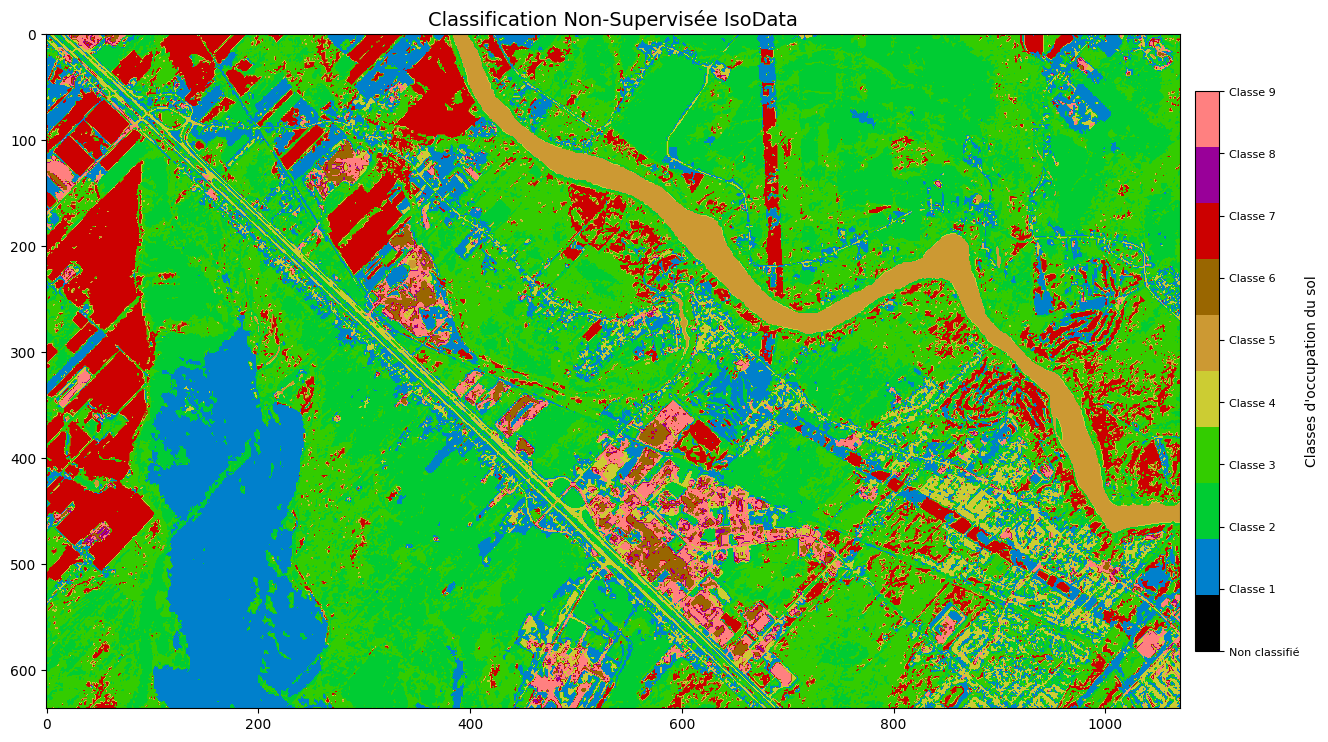


Carte de classification avec couleurs hexadécimales générée avec succès!
Image sauvegardée dans: D:\UQTR\Hiver 2025\Télédétection\TP3\output/classification_map_custom.png


In [77]:
# Cellule 8: Visualisation des résultats avec couleurs hexadécimales personnalisées
plt.figure(figsize=(12, 8)) # Increased width to have space for colorbar

# Déterminer le nombre de clusters à partir de la classification
unique_classes = np.unique(classification)
num_classes = len(unique_classes)
print(f"Classes détectées: {unique_classes}")

# Définir des couleurs personnalisées pour chaque classe en format hexadécimal
hex_colors = [
    '#000000',  # Classe 0: Noir (non classifié/fond)
    '#0080CC',  # Classe 1: Bleu (ex: eau)
    '#00CC33',  # Classe 2: Vert (ex: forêt)
    '#33CC00',  # Classe 3: Vert clair (ex: prairies)
    '#CCCC33',  # Classe 4: Jaune-vert (ex: cultures)
    '#CC9933',  # Classe 5: Marron clair (ex: sol nu)
    '#996600',  # Classe 6: Marron (ex: sol nu sec)
    '#CC0000',  # Classe 7: Rouge (ex: urbain)
    '#990099',  # Classe 8: Violet (ex: infrastructure)
    '#FF8080',  # Classe 9: Rose (ex: urbain faible densité)
    '#808080',  # Classe 10: Gris (ex: nuage/ombre)
    '#FFFF00',  # Classe 11: Jaune
    '#00BCBC',  # Classe 12: Turquoise
    '#B300B3',  # Classe 13: Magenta
    '#6666CC',  # Classe 14: Bleu-gris
    '#FF9900',  # Classe 15: Orange
    '#000080',  # Classe 16: Bleu foncé
]

# Assurez-vous d'avoir assez de couleurs
if num_classes > len(hex_colors):
    # Générer des couleurs supplémentaires si nécessaire
    import random
    for i in range(len(hex_colors), num_classes):
        # Générer une couleur hexadécimale aléatoire
        random_color = '#%02X%02X%02X' % (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        )
        hex_colors.append(random_color)

# Convertir les codes hexadécimaux en couleurs RGB pour matplotlib
from matplotlib.colors import to_rgb, ListedColormap
rgb_colors = [to_rgb(hex_color) for hex_color in hex_colors[:num_classes]]

# Créer une colormap personnalisée
custom_cmap = ListedColormap(rgb_colors)

# Créer des étiquettes pour les classes (à personnaliser selon vos besoins)
class_labels = ['Non classifié']
for i in range(1, num_classes):
    class_labels.append(f'Classe {i}')

# Afficher la classification
plt.title("Classification Non-Supervisée IsoData", fontsize=14)
im = plt.imshow(classification, cmap=custom_cmap, vmin=0, vmax=num_classes-1)

# Create a colorbar with labels, positioned outside the plot
cax = plt.axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, ticks=range(num_classes))
cbar.set_label('Classes d\'occupation du sol', fontsize=10)
cbar.ax.set_yticklabels(class_labels, fontsize=8)

# Ajouter plus d'informations à la carte
plt.axis('on')
plt.grid(False)

# Sauvegarder la figure
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "classification_map_custom.png"), dpi=300)
plt.show()

print("\nCarte de classification avec couleurs hexadécimales générée avec succès!")
print(f"Image sauvegardée dans: {output_dir}/classification_map_custom.png")

Génération des statistiques de classification...

Statistiques par classe:


,Classe,Nombre de pixels,Pourcentage (%)
0,1,116207,17.03
1,2,170989,25.06
2,3,208623,30.58
3,4,48204,7.07
4,5,21129,3.10
5,6,8751,1.28
6,7,87530,12.83
7,8,732,0.11
8,9,19735,2.89
9,10,327,0.05


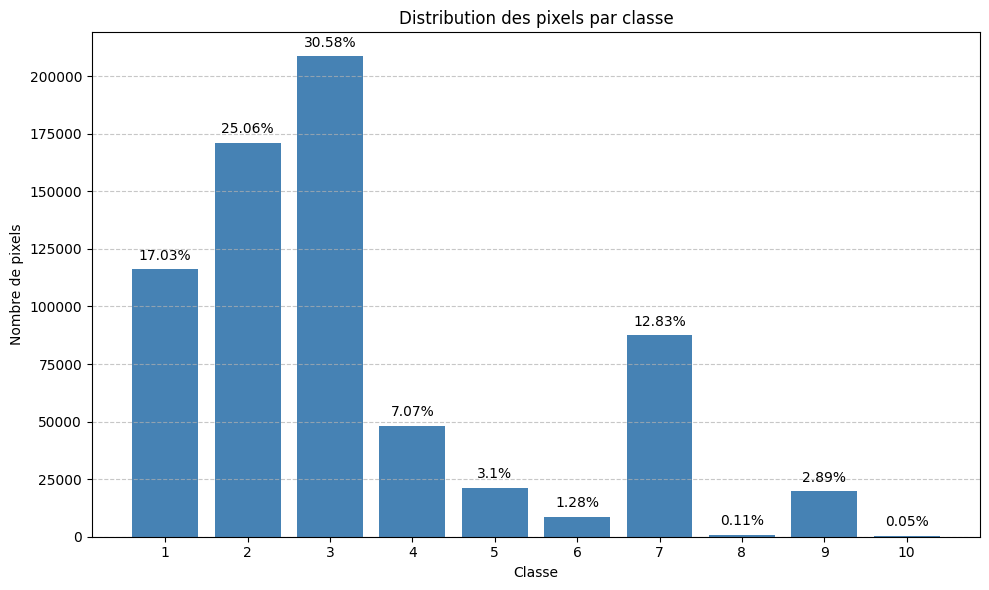


Statistiques spectrales par classe:


,Classe,Bande,Moyenne,Écart-type,Min,Max
0,1,B03_10m,1658.4081,116.3491,1318.0000,2382.0000
1,1,B05_20m,2140.9685,164.3437,1632.0000,3449.0000
2,1,B08_10m,3830.2739,391.8976,2607.0000,5716.0000
3,1,NDVI,0.7055,0.0282,0.6075,0.7894
4,2,B03_10m,1372.2556,57.8150,1147.0000,1755.0000
5,2,B05_20m,1634.1193,100.3360,1191.0000,2192.0000
6,2,B08_10m,3289.1050,307.4561,1960.0000,3974.0000
7,2,NDVI,0.7254,0.0242,0.5977,0.7676
8,3,B03_10m,1397.3738,61.5074,1221.0000,1806.0000
9,3,B05_20m,1693.2902,100.3636,1366.0000,2211.0000



Moyennes spectrales par classe:


Bande,B03_10m,B05_20m,B08_10m,NDVI
Classe,,,,
1,1658.4081,2140.9685,3830.2739,0.7055
2,1372.2556,1634.1193,3289.1050,0.7254
3,1397.3738,1693.2902,4221.0947,0.7759
4,1880.2180,2168.6570,3049.6255,0.6146
5,1199.3730,1217.8779,1258.0400,0.5119
6,2852.7139,3335.1501,3560.7913,0.5317
7,1510.3883,1833.1306,5310.0469,0.8049
8,4311.1992,4354.6011,4838.1245,0.5191
9,2305.8757,2698.8745,3224.0857,0.5648


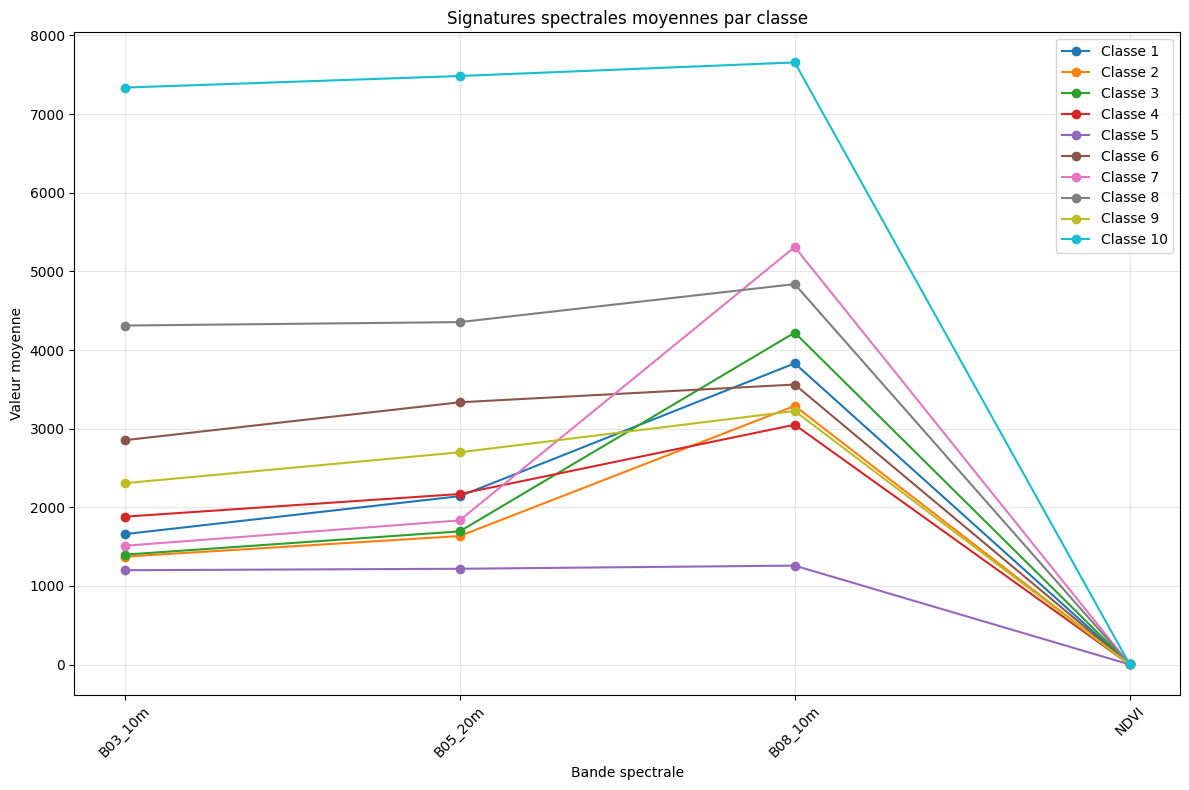


Calcul des indices de validation du clustering...
Indice de Calinski-Harabasz: 396985.7362
(Une valeur plus élevée indique une meilleure définition des clusters)
Indice de Davies-Bouldin: 0.8871
(Une valeur plus proche de zéro indique une meilleure séparation des clusters)
Échantillonnage de 10000 pixels sur 682227 pour le calcul de silhouette...
Indice de silhouette moyen: 0.3750
(Une valeur proche de 1 indique une bonne séparation des clusters)

Statistiques exportées dans D:\UQTR\Hiver 2025\Télédétection\TP3\output

Analyse des statistiques de classification terminée.


In [78]:
# Cellule: Statistiques de la classification IsoData

# Importations nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import metrics

print("Génération des statistiques de classification...")

# 1. Statistiques générales sur les classes
unique_classes, class_counts = np.unique(classification, return_counts=True)
classes_stats = pd.DataFrame({
    'Classe': unique_classes,
    'Nombre de pixels': class_counts,
    'Pourcentage (%)': (class_counts / np.sum(class_counts) * 100).round(2)
})

# Exclure la classe 0 (non classifié) si présente
if 0 in unique_classes:
    valid_pixels_count = np.sum(class_counts) - class_counts[0]
    print(f"Total de pixels classifiés: {valid_pixels_count:,} sur {np.sum(class_counts):,} pixels")
    print(f"Pourcentage classifié: {(valid_pixels_count / np.sum(class_counts) * 100):.2f}%")
    
    # Recalculer les pourcentages sans les pixels non classifiés
    classes_stats_valid = classes_stats[classes_stats['Classe'] > 0].copy()
    classes_stats_valid['Pourcentage valide (%)'] = (classes_stats_valid['Nombre de pixels'] / valid_pixels_count * 100).round(2)

print("\nStatistiques par classe:")
display(classes_stats)

# 2. Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))

# Graphique à barres des classes (exclure la classe 0 si présente)
classes_to_plot = classes_stats[classes_stats['Classe'] > 0] if 0 in unique_classes else classes_stats
plt.bar(classes_to_plot['Classe'], classes_to_plot['Nombre de pixels'], color='steelblue')
plt.xlabel('Classe')
plt.ylabel('Nombre de pixels')
plt.title('Distribution des pixels par classe')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(classes_to_plot['Classe'])

# Ajouter les étiquettes de pourcentage sur chaque barre
for i, (classe, count, pct) in enumerate(zip(
    classes_to_plot['Classe'], 
    classes_to_plot['Nombre de pixels'],
    classes_to_plot['Pourcentage (%)']
)):
    plt.text(classe, count + (max(classes_to_plot['Nombre de pixels']) * 0.02), 
             f"{pct}%", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "classes_distribution.png"), dpi=300)
plt.show()

# 3. Statistiques spectrales par classe (si les bandes sont disponibles)
try:
    # Récupérer les données des bandes utilisées pour la classification
    band_names = [src.descriptions[i-1] if i-1 < len(src.descriptions) else f"Bande {i}" for i in SELECTED_BANDS]
    
    # Créer un dataframe pour les statistiques spectrales
    spectral_stats = []
    
    # Pour chaque classe, calculer les moyennes et écarts-types des bandes
    for class_id in unique_classes:
        if class_id == 0:  # Ignorer la classe non classifiée
            continue
            
        # Masque pour cette classe
        class_mask = (classification == class_id)
        
        # Calculer les statistiques pour chaque bande
        for band_idx, band_name in zip(SELECTED_BANDS, band_names):
            band_data = src.read(band_idx)
            
            # Statistiques de la bande pour cette classe
            band_values = band_data[class_mask]
            band_mean = np.nanmean(band_values)
            band_std = np.nanstd(band_values)
            
            spectral_stats.append({
                'Classe': class_id,
                'Bande': band_name,
                'Moyenne': round(float(band_mean), 4),
                'Écart-type': round(float(band_std), 4),
                'Min': round(float(np.nanmin(band_values)), 4),
                'Max': round(float(np.nanmax(band_values)), 4)
            })
    
    # Créer le DataFrame des statistiques spectrales
    spectral_df = pd.DataFrame(spectral_stats)
    
    print("\nStatistiques spectrales par classe:")
    display(spectral_df)
    
    # Pivot table pour mieux visualiser les moyennes par classe et par bande
    pivot_means = spectral_df.pivot(index='Classe', columns='Bande', values='Moyenne')
    print("\nMoyennes spectrales par classe:")
    display(pivot_means)
    
    # Visualisation des signatures spectrales
    plt.figure(figsize=(12, 8))
    
    # Pour chaque classe, tracer la signature spectrale moyenne
    for class_id in unique_classes:
        if class_id == 0:  # Ignorer la classe non classifiée
            continue
        
        class_data = spectral_df[spectral_df['Classe'] == class_id]
        plt.plot(class_data['Bande'], class_data['Moyenne'], 'o-', label=f"Classe {class_id}")
    
    plt.title("Signatures spectrales moyennes par classe")
    plt.xlabel("Bande spectrale")
    plt.ylabel("Valeur moyenne")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "signatures_spectrales.png"), dpi=300)
    plt.show()
    
except Exception as e:
    print(f"Impossible de calculer les statistiques spectrales: {e}")

# 4. Indices de validation du clustering
print("\nCalcul des indices de validation du clustering...")
try:
    # Reformater pour le calcul des métriques
    data_for_metrics = stack.reshape(n_bands, -1).T
    valid_pixels = ~np.isnan(data_for_metrics).any(axis=1)
    valid_data = data_for_metrics[valid_pixels]
    valid_labels = classification.flatten()[valid_pixels]
    
    # Calculer les indices de validation uniquement pour les pixels classifiés
    if 0 in unique_classes:
        valid_indices = valid_labels > 0
        metrics_data = valid_data[valid_indices]
        metrics_labels = valid_labels[valid_indices]
    else:
        metrics_data = valid_data
        metrics_labels = valid_labels
    
    # Vérifier que chaque cluster a suffisamment d'échantillons
    min_samples_per_class = 10  # Minimum requis pour l'indice de silhouette
    unique_labels, label_counts = np.unique(metrics_labels, return_counts=True)
    small_clusters = [label for label, count in zip(unique_labels, label_counts) if count < min_samples_per_class]
    
    if len(small_clusters) > 0:
        print(f"Attention: {len(small_clusters)} classes ont moins de {min_samples_per_class} pixels, ce qui peut affecter les métriques de validation.")
        for cluster in small_clusters:
            print(f"  Classe {cluster}: {label_counts[list(unique_labels).index(cluster)]} pixels")
    
    # Calculer l'indice de Calinski-Harabasz
    try:
        calinski_harabasz = metrics.calinski_harabasz_score(metrics_data, metrics_labels)
        print(f"Indice de Calinski-Harabasz: {calinski_harabasz:.4f}")
        print("(Une valeur plus élevée indique une meilleure définition des clusters)")
    except Exception as e:
        print(f"Impossible de calculer l'indice de Calinski-Harabasz: {e}")
    
    # Calculer l'indice de Davies-Bouldin
    try:
        davies_bouldin = metrics.davies_bouldin_score(metrics_data, metrics_labels)
        print(f"Indice de Davies-Bouldin: {davies_bouldin:.4f}")
        print("(Une valeur plus proche de zéro indique une meilleure séparation des clusters)")
    except Exception as e:
        print(f"Impossible de calculer l'indice de Davies-Bouldin: {e}")
    
    # Calculer l'indice de silhouette si possible (pour un échantillon si les données sont trop volumineuses)
    try:
        # Si les données sont trop volumineuses, échantillonner pour le calcul de silhouette
        max_samples_for_silhouette = 10000  # Pour éviter les problèmes de mémoire
        
        if metrics_data.shape[0] > max_samples_for_silhouette:
            print(f"Échantillonnage de {max_samples_for_silhouette} pixels sur {metrics_data.shape[0]} pour le calcul de silhouette...")
            # Échantillonnage stratifié pour conserver la distribution des classes
            from sklearn.model_selection import StratifiedShuffleSplit
            
            sss = StratifiedShuffleSplit(n_splits=1, test_size=max_samples_for_silhouette, random_state=42)
            _, sample_indices = next(sss.split(metrics_data, metrics_labels))
            
            silhouette_data = metrics_data[sample_indices]
            silhouette_labels = metrics_labels[sample_indices]
        else:
            silhouette_data = metrics_data
            silhouette_labels = metrics_labels
        
        # Vérifier que tous les clusters ont au moins 2 échantillons
        unique_labels, counts = np.unique(silhouette_labels, return_counts=True)
        has_single_samples = np.any(counts < 2)
        
        if not has_single_samples:
            silhouette_avg = metrics.silhouette_score(silhouette_data, silhouette_labels)
            print(f"Indice de silhouette moyen: {silhouette_avg:.4f}")
            print("(Une valeur proche de 1 indique une bonne séparation des clusters)")
        else:
            print("Impossible de calculer l'indice de silhouette: certaines classes n'ont qu'un seul élément.")
    
    except Exception as e:
        print(f"Impossible de calculer l'indice de silhouette: {e}")

except Exception as e:
    print(f"Impossible de calculer les indices de validation: {e}")

# 5. Exporter les statistiques en CSV
try:
    # Statistiques des classes
    classes_stats.to_csv(os.path.join(output_dir, "classes_statistics.csv"), index=False)
    
    # Statistiques spectrales
    if 'spectral_df' in locals():
        spectral_df.to_csv(os.path.join(output_dir, "spectral_statistics.csv"), index=False)
        
    print(f"\nStatistiques exportées dans {output_dir}")
except Exception as e:
    print(f"Erreur lors de l'exportation des statistiques: {e}")

print("\nAnalyse des statistiques de classification terminée.")